In [1]:
import pandas as pd
import gridstatus as gs
gs.__version__

'0.18.0'

Which ISO apis work? Which columns are aligned?

In [2]:
gs.list_isos()["Id"].to_list()

['miso', 'caiso', 'pjm', 'ercot', 'spp', 'nyiso', 'isone']

In [3]:
iso_classes = {"miso": gs.MISO,
"caiso": gs.CAISO,
"pjm": gs.PJM,
"ercot": gs.Ercot,
"spp": gs.SPP,
"nyiso": gs.NYISO,
"isone": gs.ISONE}

In [4]:
queue_dfs = {}
for iso_id, iso_class in iso_classes.items():
    try:
        df = iso_class().get_interconnection_queue()
        df["iso_id"] = iso_id
        queue_dfs[iso_id] = df
    except:
        print(iso_id)
        

In [5]:
shared_columns = set.intersection(*[set(df.columns) for df in queue_dfs.values()])

shared_columns

{'Actual Completion Date',
 'Capacity (MW)',
 'County',
 'Generation Type',
 'Interconnecting Entity',
 'Interconnection Location',
 'Project Name',
 'Proposed Completion Date',
 'Queue Date',
 'Queue ID',
 'State',
 'Status',
 'Summer Capacity (MW)',
 'Transmission Owner',
 'Winter Capacity (MW)',
 'Withdrawal Comment',
 'Withdrawn Date',
 'iso_id'}

In [6]:
queues = pd.concat(queue_dfs.values())
queues = queues[shared_columns]

In [7]:
queues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19879 entries, 0 to 1300
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Actual Completion Date    1513 non-null   object 
 1   Project Name              14599 non-null  object 
 2   iso_id                    19879 non-null  object 
 3   Capacity (MW)             19474 non-null  float64
 4   Queue Date                19478 non-null  object 
 5   State                     18979 non-null  object 
 6   Queue ID                  19879 non-null  object 
 7   Transmission Owner        17318 non-null  object 
 8   Winter Capacity (MW)      15193 non-null  object 
 9   Interconnecting Entity    1919 non-null   object 
 10  Proposed Completion Date  9297 non-null   object 
 11  Summer Capacity (MW)      15223 non-null  object 
 12  Status                    19865 non-null  object 
 13  Withdrawn Date            8641 non-null   object 
 14  Withdra

## Clean up Queue Date

In [8]:
queues["Queue Date"] = pd.to_datetime(queues["Queue Date"], utc=True, errors="coerce")

## Capacity

In [9]:
queues["Capacity (MW)"].isna().value_counts()

False    19474
True       405
Name: Capacity (MW), dtype: int64

In [10]:
no_capacity = (queues["Capacity (MW)"] <= 0)
no_capacity.value_counts()

False    19361
True       518
Name: Capacity (MW), dtype: int64

There are a few hundred projects that are missing capacity or have 0 capacity.

<AxesSubplot: >

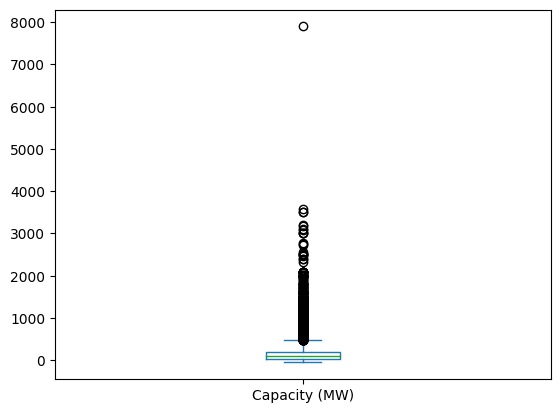

In [11]:
queues["Capacity (MW)"].plot.box()

## Status

In [12]:
queues["Status"].value_counts()

Withdrawn                                    7467
Active                                       6608
WITHDRAWN                                    1610
In Service                                   1032
Done                                          775
Completed                                     758
ACTIVE                                        463
Engineering and Procurement                   326
Confirmed                                     223
COMPLETED                                     202
Retracted                                     131
Suspended                                      77
Deactivated                                    57
Partially in Service - Under Construction      56
Under Construction                             52
Annulled                                       24
Withdrawn - Pending Cure                        3
                                                1
Name: Status, dtype: int64

In [13]:
queues["Status"] = queues["Status"].str.strip().str.lower()

In [14]:
queues["Status"].value_counts()

withdrawn                                    9077
active                                       7071
in service                                   1032
completed                                     960
done                                          775
engineering and procurement                   326
confirmed                                     223
retracted                                     131
suspended                                      77
deactivated                                    57
partially in service - under construction      56
under construction                             52
annulled                                       24
withdrawn - pending cure                        3
                                                1
Name: Status, dtype: int64

In [15]:
queues["Status"].isna().value_counts()

False    19865
True        14
Name: Status, dtype: int64

Cool! Most of the projects have a status though the values need some harmonizing.

## Location

In [16]:
def replace_whitespace(s: pd.Series) -> pd.Series:
    return s.str.strip().replace("", pd.NA).fillna(pd.NA)

In [17]:
queues["County"] = queues["County"].pipe(replace_whitespace)
queues["County"].isna().value_counts()

False    18870
True      1009
Name: County, dtype: int64

In [18]:
queues["State"] = queues["State"].pipe(replace_whitespace)
queues["State"].isna().value_counts()

False    18973
True       906
Name: State, dtype: int64

There are a couple hundred of projects that do not have state or county information.

## Resource Type

In [19]:
queues["Generation Type"] = replace_whitespace(queues["Generation Type"])
queues["Generation Type"].isna().value_counts()

False    18541
True      1338
Name: Generation Type, dtype: int64

In [20]:
queues["Generation Type"].value_counts().head(20)

Solar                             5724
Wind                              2625
Storage                           1453
Natural Gas                       1108
Photovoltaic                       708
Solar; Storage                     535
Solar - Photovoltaic Solar         469
Other - Battery Energy Storage     467
Battery Storage                    456
Energy Storage                     333
SUN                                330
Hybrid                             272
Coal                               237
Photovoltaic + Storage             233
Gas                                233
WND                                225
Methane                            215
Wind Turbine                       195
Combined Cycle                     186
Storage + Photovoltaic             184
Name: Generation Type, dtype: int64

Ooof about 1200 projects are missing a fuel type. Maybe the projects with missing fuel type are from a specific ISO or time range.

In [21]:
missing_type = queues[queues["Generation Type"].isna()].copy()
missing_type["Status"].value_counts()

withdrawn                                    851
confirmed                                    223
retracted                                    131
active                                        64
in service                                    29
annulled                                      24
done                                          14
                                               1
partially in service - under construction      1
Name: Status, dtype: int64

<AxesSubplot: >

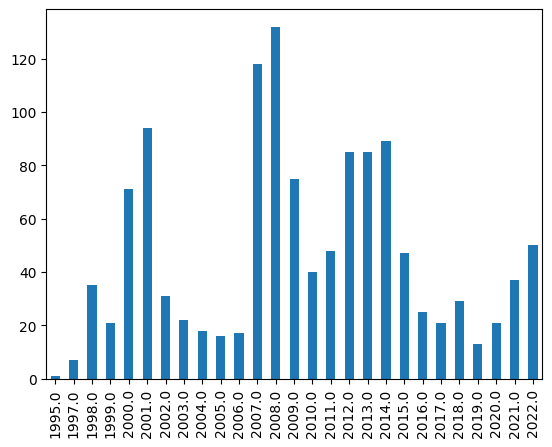

In [22]:
missing_type["Queue Date"].dt.year.value_counts().sort_index().plot.bar()

It looks like most are withdrawn so that's good.

## Time range

### Project status counts by year

In [23]:
status_by_year = queues.groupby([queues["Queue Date"].dt.year, queues["Status"]]).count()["Queue ID"].reset_index()
status_by_year

,Queue Date,Status,Queue ID
0,1900.0,done,1
1,1989.0,completed,1
2,1995.0,withdrawn,1
3,1996.0,withdrawn,1
4,1997.0,in service,10
...,...,...,...
208,2022.0,active,2085
209,2022.0,completed,4
210,2022.0,done,4
211,2022.0,withdrawn,203


<AxesSubplot: xlabel='Queue Date'>

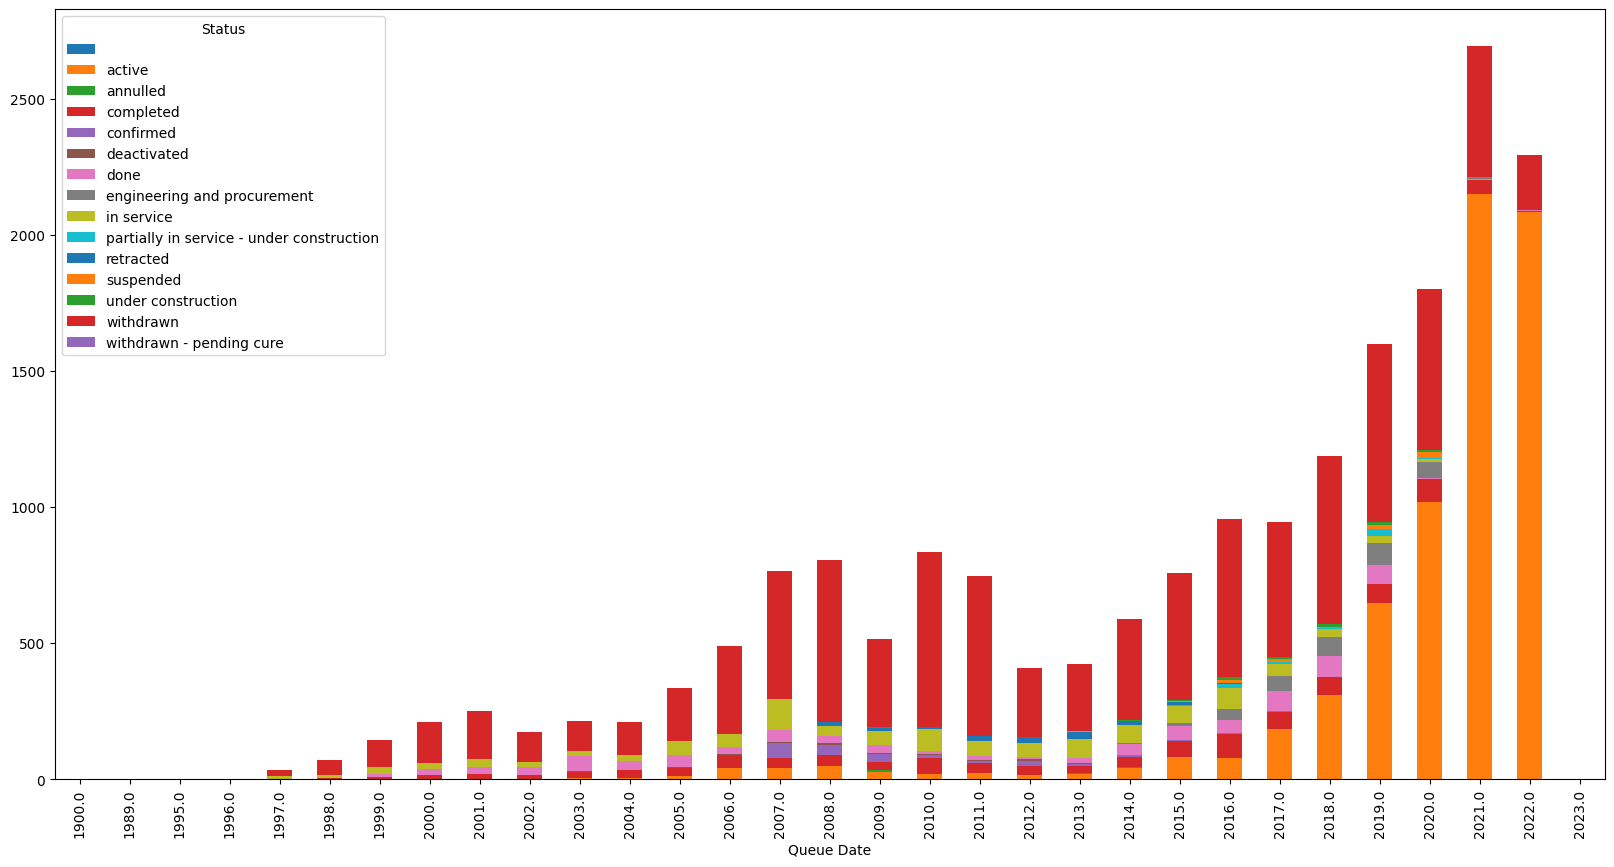

In [24]:
status_by_year.pivot(index="Queue Date", columns="Status", values="Queue ID").plot.bar(stacked=True, figsize=(20,10))

### Project type total Capacity by year

In [25]:
type_by_year = queues.groupby([queues["Queue Date"].dt.year, queues["Generation Type"]]).sum()["Capacity (MW)"].reset_index()
type_by_year

,Queue Date,Generation Type,Capacity (MW)
0,1900.0,Wind,80.00
1,1989.0,AC Transmission,0.00
2,1996.0,NG,0.00
3,1997.0,Coal,6.00
4,1997.0,DFO NG,0.00
...,...,...,...
898,2022.0,WND,4775.00
899,2022.0,Wind,58854.19
900,2022.0,Wind - Wind Turbine,2573.22
901,2023.0,Storage,44.00


In [26]:
# This is pretty unreadable due to the number of categories
# type_by_year.pivot(index="Queue Date", columns="Generation Type", values="Capacity (MW)").plot.bar(stacked=True, figsize=(20,10))

## Most recent projects

In [27]:
queues.groupby("iso_id")["Queue Date"].max()

iso_id
caiso   2023-01-04 08:00:00+00:00
ercot   2022-12-15 00:00:00+00:00
isone   2022-09-30 00:00:00+00:00
miso    2023-01-06 05:00:00+00:00
nyiso   2022-12-01 00:00:00+00:00
pjm     2022-12-20 00:00:00+00:00
spp     2022-12-16 00:00:00+00:00
Name: Queue Date, dtype: datetime64[ns, UTC]

- When was the most recent queue in the NBLN dataset?
- Read the ISO API docs to understand how often these update. Looks like they're all pretty current.

## Duplicates

In [28]:
iso_queue_id_group = queues.groupby("iso_id")["Queue ID"]

print(iso_queue_id_group.nunique() / iso_queue_id_group.count())

iso_id
caiso    1.000000
ercot    1.000000
isone    0.900846
miso     0.999765
nyiso    1.000000
pjm      1.000000
spp      1.000000
Name: Queue ID, dtype: float64


In [29]:
has_duplicates = queues[["iso_id", "Queue ID"]].duplicated(keep=False)
has_duplicates.value_counts()

False    19669
True       210
dtype: int64

Surprisingly few duplicates! Should look potential projects that have different queues ids but similar project attributes.

<AxesSubplot: >

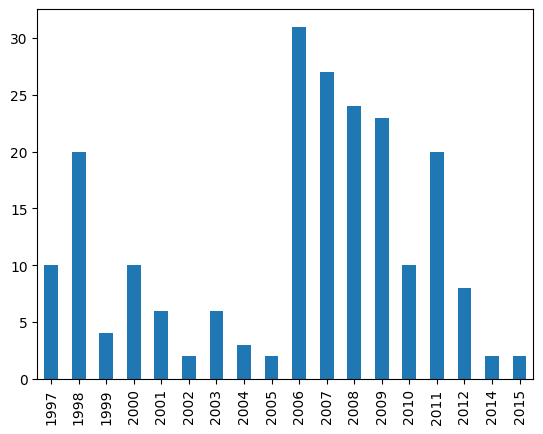

In [30]:
duplicate_projects = queues[has_duplicates]
duplicate_projects["Queue Date"].dt.year.value_counts().sort_index().plot.bar()

<AxesSubplot: >

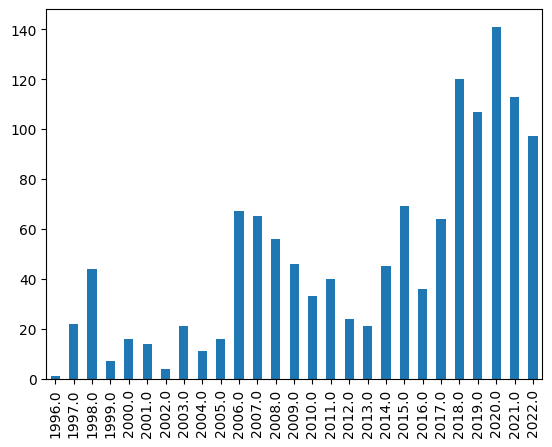

In [31]:
queues.query("iso_id == 'isone'")["Queue Date"].dt.year.value_counts().sort_index().plot.bar()

In [32]:
duplicate_projects.iso_id.value_counts()

isone    208
miso       2
Name: iso_id, dtype: int64

It looks like ISONE is the trouble maker here. ISONE hasn't created a duplicate queue id since 2015 despite having hundreds of project in their queue since then. For the sake of time I'm going to assume they no longer produce duplicate queue ids.

In [33]:
duplicate_projects[["Queue ID", "iso_id"]].value_counts()

Queue ID  iso_id
73        isone     8
33        isone     6
272       isone     6
84        isone     6
161       isone     5
                   ..
254       isone     2
255       isone     2
257       isone     2
259       isone     2
J392      miso      2
Length: 80, dtype: int64

In [34]:
iso_id = "isone"
queue_id = 73
duplicate_projects.query("iso_id == @iso_id & `Queue ID` == @queue_id")

,Actual Completion Date,Project Name,iso_id,Capacity (MW),Queue Date,State,Queue ID,Transmission Owner,Winter Capacity (MW),Interconnecting Entity,Proposed Completion Date,Summer Capacity (MW),Status,Withdrawn Date,Withdrawal Comment,Generation Type,County,Interconnection Location
79,None,Devon A,isone,NaN,2000-07-07 00:00:00+00:00,CT,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,New Haven,Devon 115 kV Substation
80,None,Norwalk Harbor A,isone,NaN,2000-07-07 00:00:00+00:00,CT,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,Fairfield,Norwalk 115 kV Station
81,None,Norwalk Harbor B,isone,NaN,2000-07-07 00:00:00+00:00,CT,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,Fairfield,Norwalk 115 kV Station
82,None,Middletown A,isone,NaN,2000-07-07 00:00:00+00:00,CT,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,Middlesex,Middletown Station
83,None,Montville A,isone,NaN,2000-07-07 00:00:00+00:00,CT,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,New London,Montville Station
84,None,Somerset A,isone,NaN,2000-07-07 00:00:00+00:00,MA,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,Bristol,Somerset 115 kV Station
85,None,Middletown B,isone,NaN,2000-07-07 00:00:00+00:00,CT,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,Middlesex,Middletown Station
86,None,Somerset Diversity,isone,NaN,2000-07-07 00:00:00+00:00,MA,73,NaN,NaN,None,NaT,NaN,withdrawn,NaT,None,<NA>,Bristol,Somerset 115 kV Station


## Are there duplicates with different Queue IDs?

In [35]:
caiso_queue = queues.query("iso_id == 'caiso'")

In [36]:
# identity_columns = ["State", "County", "Queue Date", "Capacity (MW)", "Project Name"]
identity_columns = ["State", "County", "Project Name"]
potential_dups = queues.duplicated(subset=identity_columns, keep=False)
potential_dups.value_counts()

False    11316
True      8563
dtype: int64

In [37]:
queues[potential_dups].sort_values(by="Project Name")

,Actual Completion Date,Project Name,iso_id,Capacity (MW),Queue Date,State,Queue ID,Transmission Owner,Winter Capacity (MW),Interconnecting Entity,Proposed Completion Date,Summer Capacity (MW),Status,Withdrawn Date,Withdrawal Comment,Generation Type,County,Interconnection Location
310,NaT,ALLIUM,caiso,110.0,2021-04-15 07:00:00+00:00,CA,1921,PGAE,None,None,2025-06-01 07:00:00,None,active,NaT,NaN,Storage + Photovoltaic,SAN BENITO,Crazy Horse Canyon - Hollister 115 lV
2057,NaT,ALLIUM,caiso,110.0,2020-04-15 07:00:00+00:00,CA,1711,PGAE,None,None,2023-12-01 08:00:00,None,withdrawn,2021-04-14 07:00:00,IC Request,Photovoltaic + Storage,SAN BENITO,Hollister Substation 115kV
2520,NaN,ALTE-PJM,pjm,156.0,2011-12-29 00:00:00+00:00,<NA>,X4-029C 3396292,NaN,NaN,None,NaN,NaN,retracted,NaN,NaN,<NA>,<NA>,None
2521,NaN,ALTE-PJM,pjm,156.0,2011-12-29 00:00:00+00:00,<NA>,X4-029D 3396293,NaN,NaN,None,NaN,NaN,confirmed,NaN,NaN,<NA>,<NA>,None
2582,NaN,ALTE-PJM,pjm,156.0,2012-03-27 00:00:00+00:00,<NA>,Y1-041 4019603,NaN,NaN,None,NaN,NaN,confirmed,NaN,NaN,<NA>,<NA>,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,None,None,spp,99.0,2003-06-05 00:00:00+00:00,OK,GEN-2003-005,WFEC,99.0,None,NaN,99.0,completed,None,None,Wind,Apache,Anadarko - Paradise (Blue Canyon) 138kV
784,None,None,spp,100.0,2003-06-05 00:00:00+00:00,OK,GEN-2003-004,WFEC,100.0,None,12/15/2005,100.0,completed,None,None,Wind,Apache,Washita 138kV
788,None,None,spp,67.2,2002-07-19 00:00:00+00:00,TX,GEN-2002-009,SPS,67.2,None,9/30/2006,67.2,completed,None,None,Wind,Hansford County,Hansford 115kV
789,None,None,spp,240.0,2002-07-19 00:00:00+00:00,TX,GEN-2002-008,SPS,240.0,None,12/30/2008,240.0,completed,None,None,Wind,Hansford County,Hitchland 345kV


In [38]:
queues.groupby("iso_id", dropna=False)["Project Name"].count()

iso_id
caiso    2275
ercot    1083
isone    1301
miso        0
nyiso    1469
pjm      8471
spp         0
Name: Project Name, dtype: int64

In [39]:
iso_classes

{'miso': gridstatus.miso.MISO,
 'caiso': gridstatus.caiso.CAISO,
 'pjm': gridstatus.pjm.PJM,
 'ercot': gridstatus.ercot.Ercot,
 'spp': gridstatus.spp.SPP,
 'nyiso': gridstatus.nyiso.NYISO,
 'isone': gridstatus.isone.ISONE}

## Sources
- NYISO: Excel sheet that [updated monthly](https://www.nyiso.com/interconnections).
- MISO: API
- PJM: Reads from an excel file.  Most recent project was 2022-12-20
- CAISO: Reads from an [excel file](http://www.caiso.com/planning/Pages/GeneratorInterconnection/Default.aspx). Not clear how often it is updated. Most recent projects was 2023-01-04
- ERCOT: Reads from an excel file that is [updated monthly](https://www.ercot.com/mp/data-products/data-product-details?id=PG7-200-ER).
- ISONE: Reads from an excel file that is [updated daily](https://irtt.iso-ne.com/reports/external). Some [important notes](https://www.iso-ne.com/system-planning/interconnection-service/interconnection-request-queue/) about working with the data.
- SPP: CSV [updated daily](https://opsportal.spp.org/Studies/GIActive). [Information page](https://www.spp.org/engineering/generator-interconnection/)

# Compare to LBNL

In [40]:
from dbcp.helpers import get_sql_engine

engine = get_sql_engine()

/app/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [106]:
with engine.connect() as con:
    iso_projects_2021 = pd.read_sql_table("iso_projects_wide_format", con, schema="data_mart")

In [107]:
iso_projects_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7630 entries, 0 to 7629
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   project_id                         7630 non-null   int64         
 1   project_name                       2298 non-null   object        
 2   iso_region                         7630 non-null   object        
 3   entity                             7630 non-null   object        
 4   utility                            6332 non-null   object        
 5   developer                          1087 non-null   object        
 6   state                              7441 non-null   object        
 7   county                             7424 non-null   object        
 8   state_id_fips                      7441 non-null   object        
 9   county_id_fips                     7424 non-null   object        
 10  resource_class                     7

In [109]:
iso_projects_2021.iso_region.value_counts()

PJM                    2577
West (non-ISO)         1080
MISO                    927
ERCOT                   647
Southeast (non-ISO)     606
CAISO                   593
SPP                     520
NYISO                   374
ISO-NE                  306
Name: iso_region, dtype: int64

<AxesSubplot: >

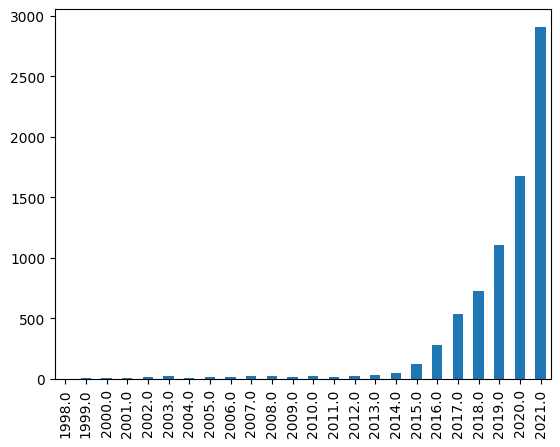

In [111]:
iso_projects_2021.date_entered_queue.dt.year.value_counts().sort_index().plot.bar()

These are Active project through the end of 2021 in ISOs plus some non ISO utilities. To compare these two datasets we need to:
- Filter gridstatus to just active projects. Status is not a harmonized column so we may need to filter on multiple values
- Find all withrawn or complete projects that entered the queue prior to the end of 2021 but have a withdrawn data in 2022 and set the status to active.
- Filter lbnl to just ISOs

## Filter LBNL


In [112]:
isos = ["PJM",
"MISO",
"ERCOT",
"CAISO",
"SPP",
"NYISO",
"ISO-NE",]

lbnl_iso_projects = iso_projects_2021[iso_projects_2021.iso_region.isin(isos)].copy()
lbnl_iso_projects.iso_region.value_counts()

PJM       2577
MISO       927
ERCOT      647
CAISO      593
SPP        520
NYISO      374
ISO-NE     306
Name: iso_region, dtype: int64

## Filter gridstatus

In [64]:
queues["Status"].value_counts()

withdrawn                                    9077
active                                       7071
in service                                   1032
completed                                     960
done                                          775
engineering and procurement                   326
confirmed                                     223
retracted                                     131
suspended                                      77
deactivated                                    57
partially in service - under construction      56
under construction                             52
annulled                                       24
withdrawn - pending cure                        3
                                                1
Name: Status, dtype: int64

In [75]:
queues["Withdrawn Date"] = pd.to_datetime(queues["Withdrawn Date"], utc=True, errors="coerce")

In [78]:
formerly_active_projects = (queues["Withdrawn Date"].dt.year > 2021) & (queues["Queue Date"].dt.year < 2022)

formerly_active_projects.value_counts()

False    19479
True       400
dtype: int64

In [82]:
queues[formerly_active_projects]["Status"].value_counts()

withdrawn    361
active        37
done           2
Name: Status, dtype: int64

Not sure why some active projects have a withdraw date. Most with a withdrawn date are are actually withdrawn so I will continue to set them active for this comparison.

In [84]:
queues["lbnl_status"] = queues["Status"]

In [97]:
queues["lbnl_status"] = queues["Status"].mask(formerly_active_projects, "active")

# Make sure the mask worked as expected. 37 is the number of active projects that have a withdrawn date
assert len(queues.query("Status == 'active'")) + formerly_active_projects.sum() - 37 == len(queues.query("lbnl_status == 'active'"))

In [98]:
queues["Status"].value_counts()

withdrawn                                    9077
active                                       7071
in service                                   1032
completed                                     960
done                                          775
engineering and procurement                   326
confirmed                                     223
retracted                                     131
suspended                                      77
deactivated                                    57
partially in service - under construction      56
under construction                             52
annulled                                       24
withdrawn - pending cure                        3
                                                1
Name: Status, dtype: int64

In [99]:
queues.lbnl_status.value_counts()

withdrawn                                    8716
active                                       7434
in service                                   1032
completed                                     960
done                                          773
engineering and procurement                   326
confirmed                                     223
retracted                                     131
suspended                                      77
deactivated                                    57
partially in service - under construction      56
under construction                             52
annulled                                       24
withdrawn - pending cure                        3
                                                1
Name: lbnl_status, dtype: int64

In [100]:
gridstatus_iso_projects = queues.query("lbnl_status == 'active'").copy()
gridstatus_iso_projects.lbnl_status.value_counts()

active    7434
Name: lbnl_status, dtype: int64

## Compare!
- Number of projects, by year, by region
- Capcity by year, and region

In [134]:
print(gridstatus_iso_projects.iso_id.value_counts())
print()
print(lbnl_iso_projects.iso_region.value_counts())

pjm      2827
miso     1661
ercot     775
caiso     599
nyiso     561
isone     549
spp       462
Name: iso_id, dtype: int64

PJM       2577
MISO       927
ERCOT      647
CAISO      593
SPP        520
NYISO      374
ISO-NE     306
Name: iso_region, dtype: int64


LBNL generally has less projects but that could be do to the deduplication we do for LBNL. There are probably some duplicates in gridstatus I didn't have time to  The distribution of projects between ISO is pretty similar.

count    7371.000000
mean      173.848182
std       221.589475
min       -53.300000
25%        50.000000
50%       110.000000
75%       200.000000
max      3200.000000
Name: Capacity (MW), dtype: float64


<AxesSubplot: >

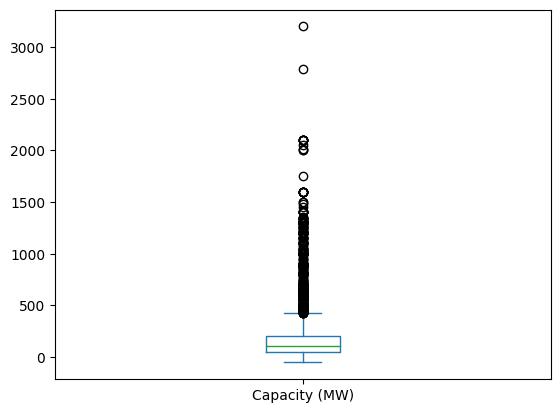

In [135]:
print(gridstatus_iso_projects["Capacity (MW)"].describe())
gridstatus_iso_projects["Capacity (MW)"].plot.box()

In [136]:
print(lbnl_iso_projects.generation_capacity_mw_1.describe())

count    4544.000000
mean      153.684120
std       199.960698
min         0.170000
25%        29.000000
50%       100.000000
75%       200.000000
max      3200.000000
Name: generation_capacity_mw_1, dtype: float64


<AxesSubplot: >

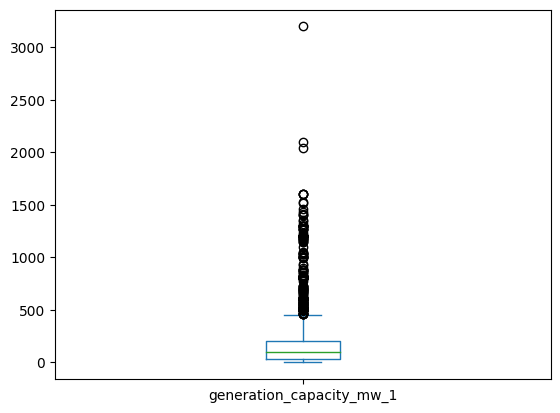

In [137]:
lbnl_iso_projects.generation_capacity_mw_1.plot.box()

In [113]:
lbnl_iso_projects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5944 entries, 0 to 5946
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   project_id                         5944 non-null   int64         
 1   project_name                       2190 non-null   object        
 2   iso_region                         5944 non-null   object        
 3   entity                             5944 non-null   object        
 4   utility                            4733 non-null   object        
 5   developer                          1021 non-null   object        
 6   state                              5867 non-null   object        
 7   county                             5854 non-null   object        
 8   state_id_fips                      5867 non-null   object        
 9   county_id_fips                     5854 non-null   object        
 10  resource_class                     5

The MW capacities are pretty dang similar! Should do a proper comparison but looks pretty good just comparing the quantiles.

## Looks at 2022
What are we missing out on by using LBNL?

<AxesSubplot: >

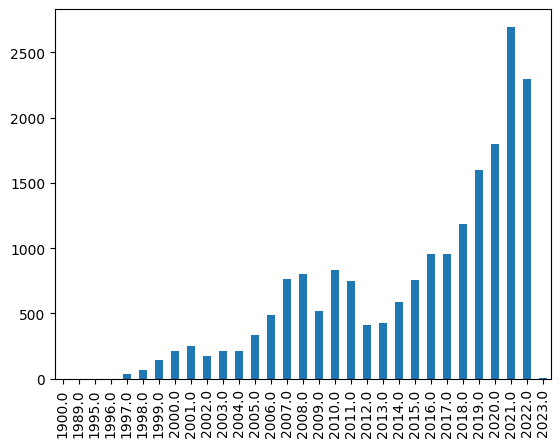

In [142]:
queues["Queue Date"].dt.year.value_counts().sort_index().plot.bar()

<AxesSubplot: xlabel='Queue Date'>

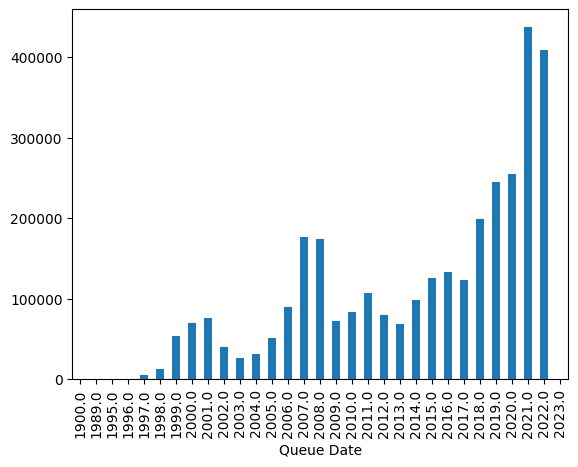

In [148]:
queues.groupby(queues["Queue Date"].dt.year)["Capacity (MW)"].sum().plot.bar()

ISO Queues actually got a little smaller in 2022 in terms of projects and capacity. Still missing out on > 2000 projects and 400 GW of electricity though.